In [3]:
BAND = "r"
NON_EXTENDED_ONLY = True

N_SRC = 10
BATCH_SIZE = 32
N_LCS = 500_000

DP1_ROOT = "../../data/dp1"
LSDB_WORKERS = 8
DEVICE = "mps"

PLOT_ON_TEST_SET = False
PLOT_MAGS = [18, 21, 25]

/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for

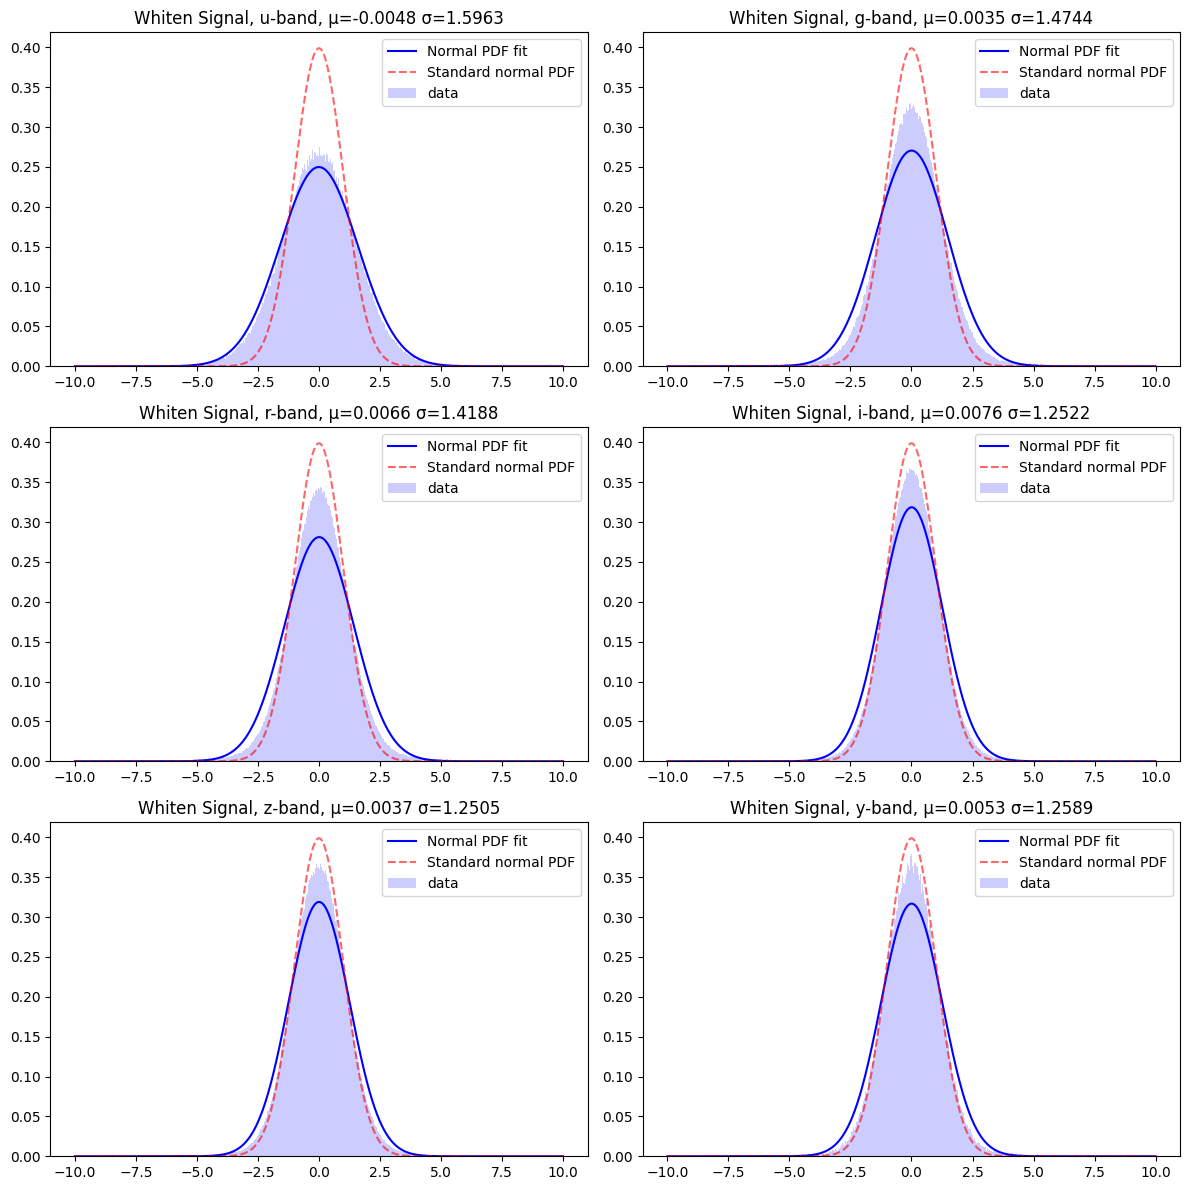

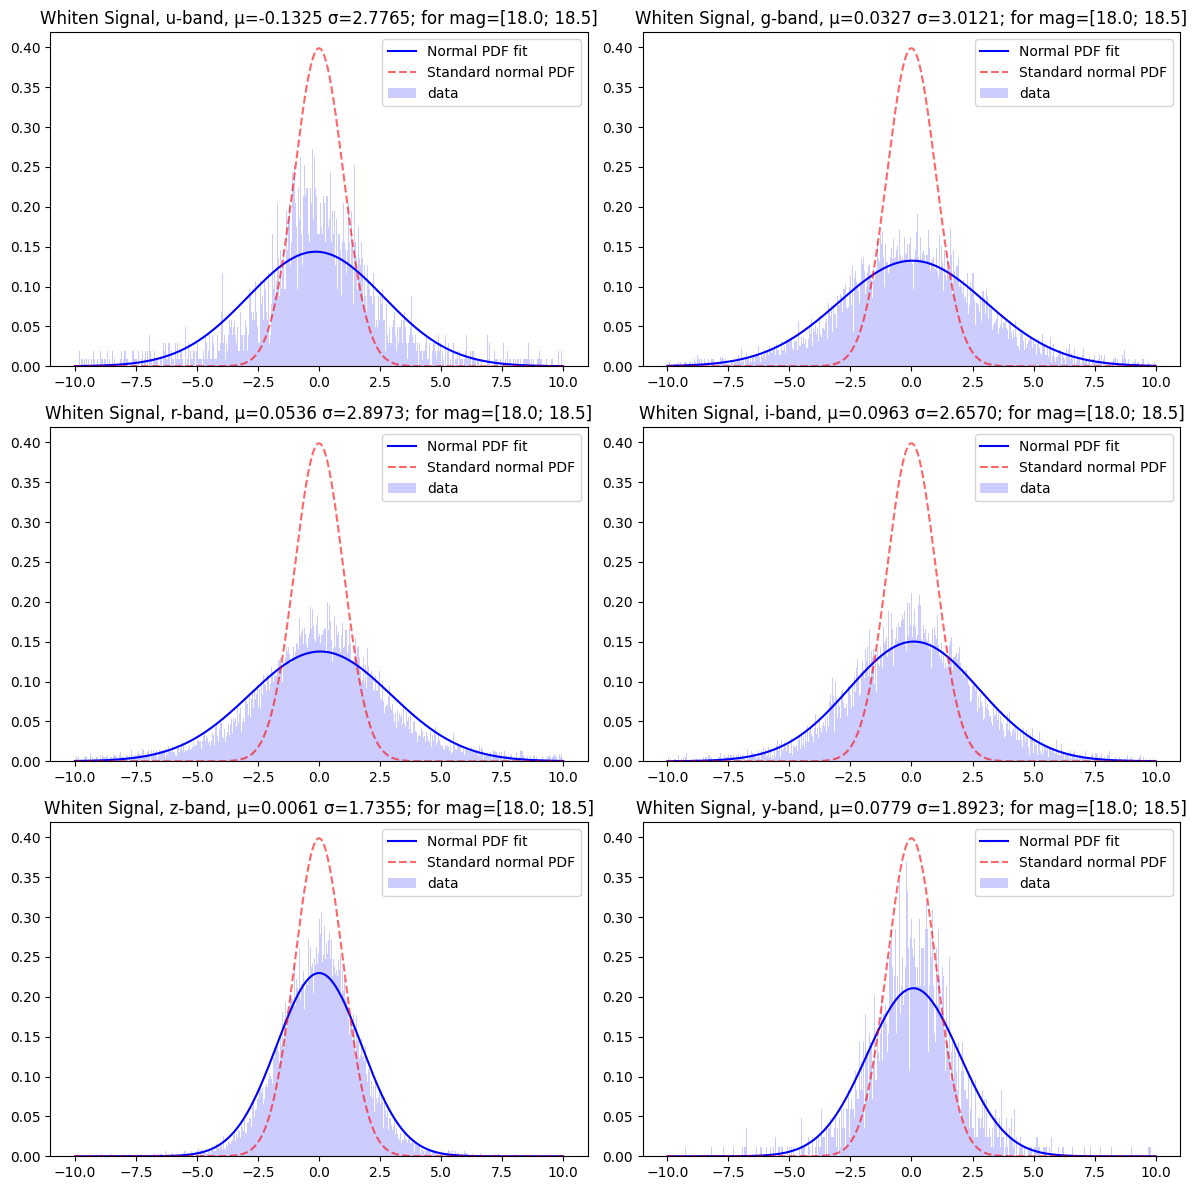

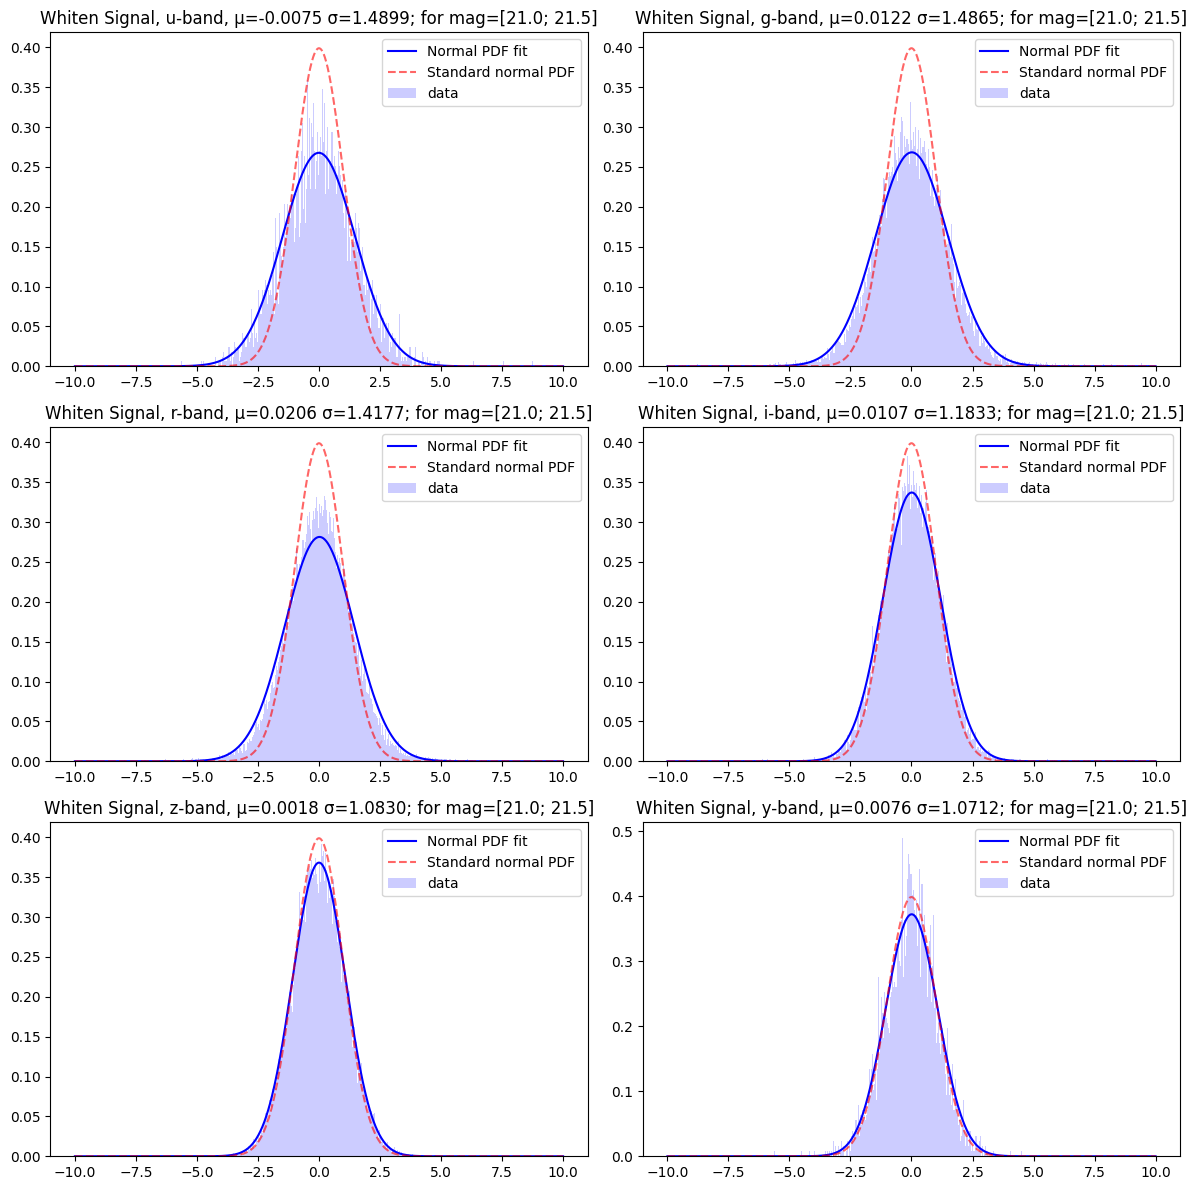

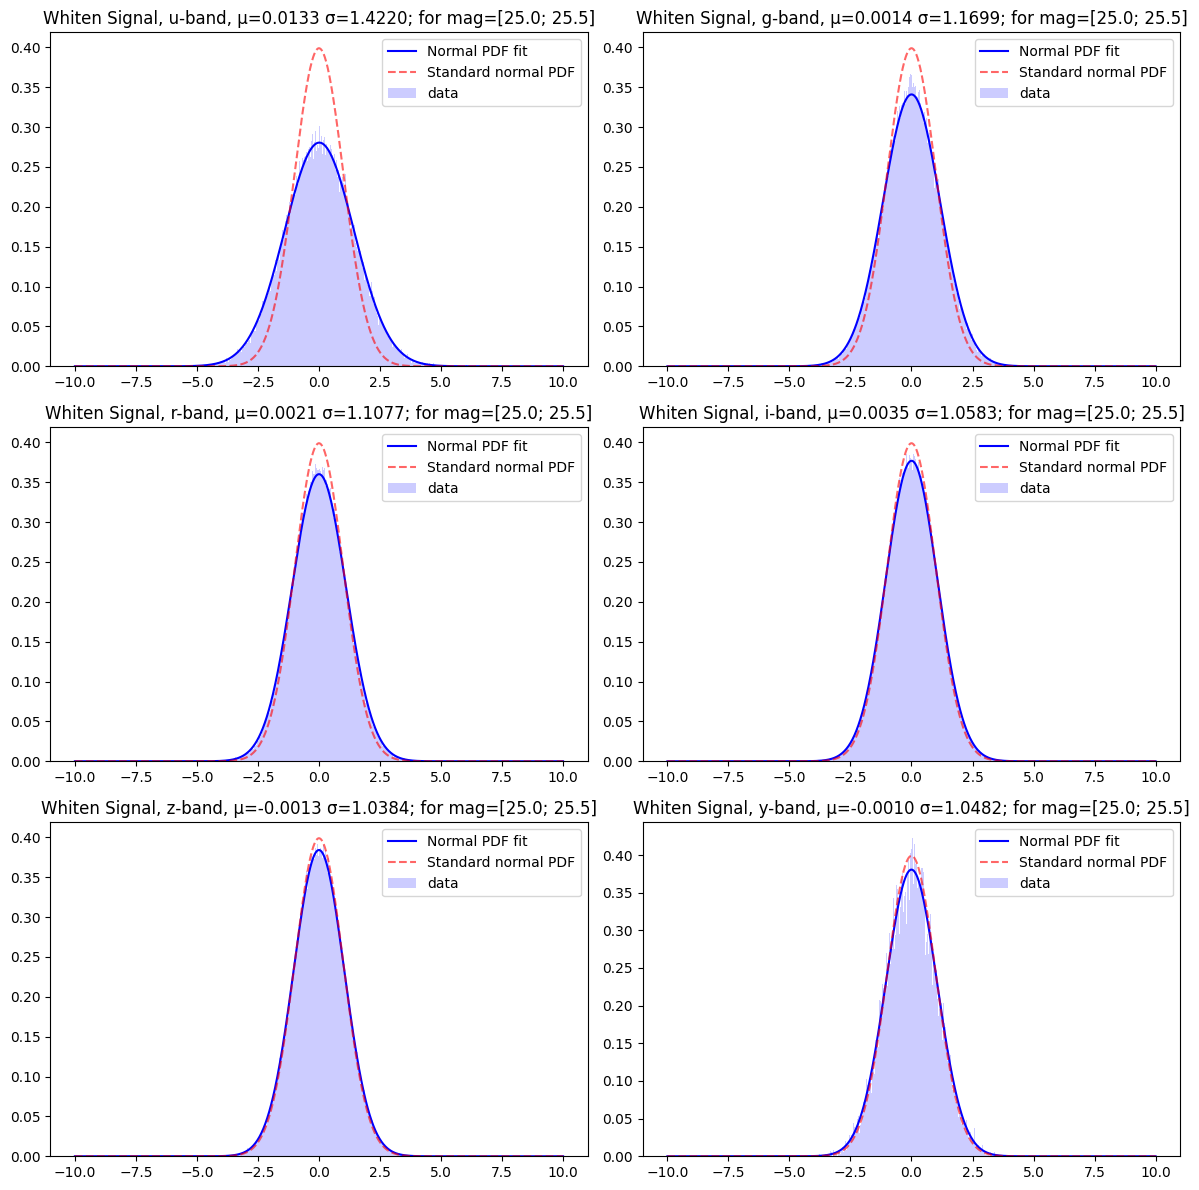

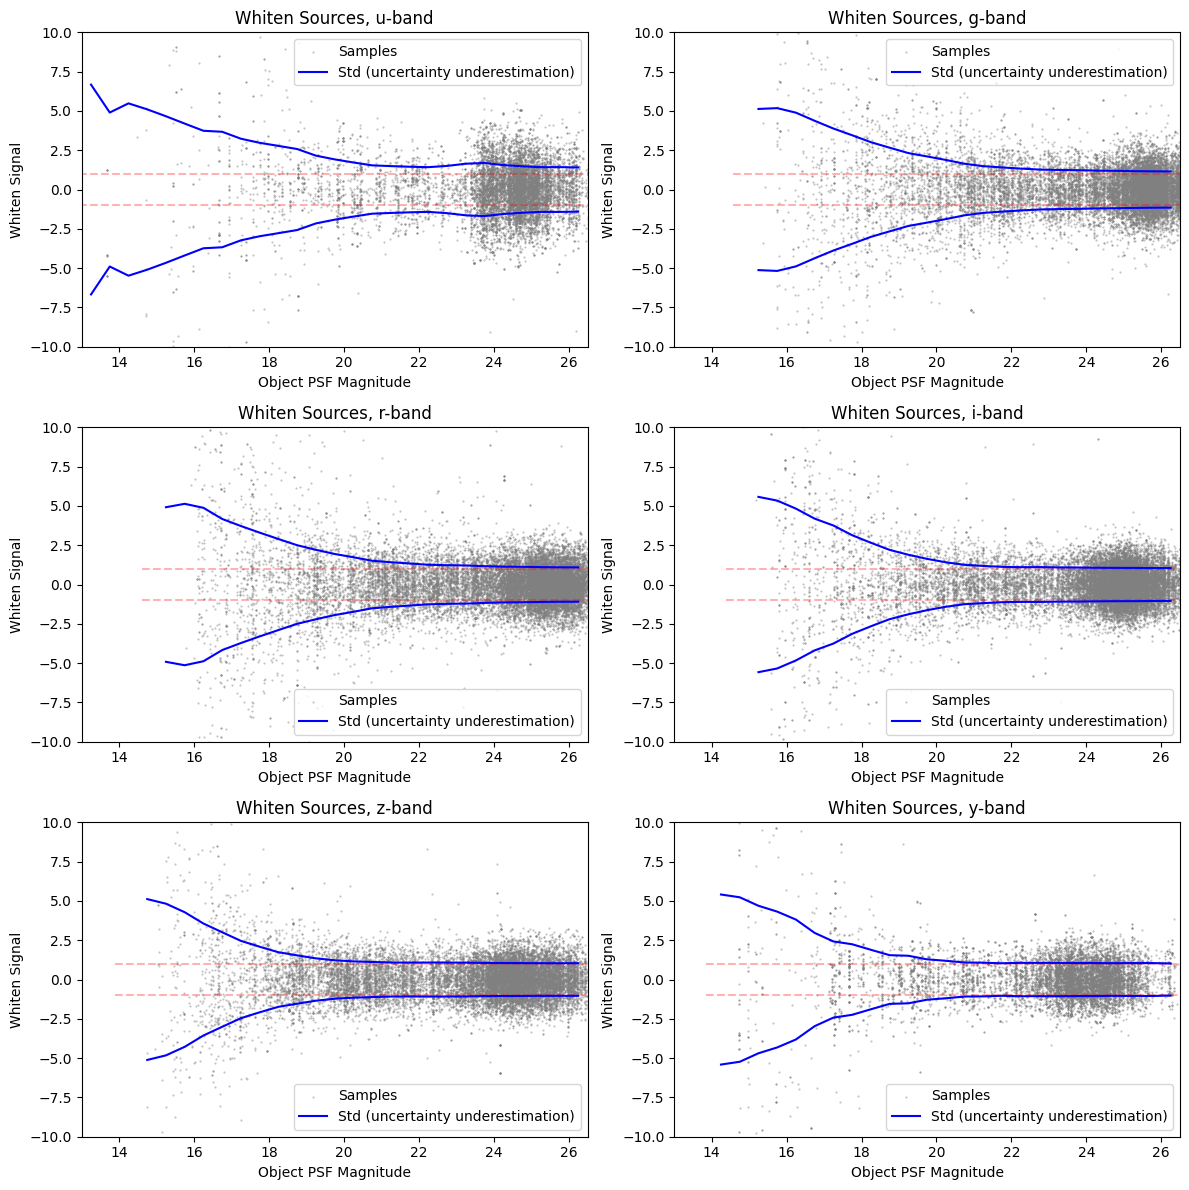

In [2]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    test_only=PLOT_ON_TEST_SET,
    min_n_src=N_SRC,
    non_extended_only=NON_EXTENDED_ONLY,
    n_workers=LSDB_WORKERS,
    model=None,
    n_samples=5,
    object_mags=[18, 21, 25],
)

In [3]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
from uncle_val.pipelines import run_dp1_linear_flux_err

model_path = run_dp1_linear_flux_err(
    dp1_root=DP1_ROOT,
    band=BAND,
    non_extended_only=NON_EXTENDED_ONLY,
    n_workers=LSDB_WORKERS,
    n_src=N_SRC,
    n_lcs=N_LCS,
    train_batch_size=BATCH_SIZE,
    start_tfboard=False,
    output_root="./runs",
    device=DEVICE,
)

Dask Dashboard Link: http://127.0.0.1:8787/status


Validation batches:   0%|          | 0/122 [00:00<?, ?it/s]

2025-10-09 16:22:28,813 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('apply_func-907ed5f679a8ece24f852f4ec5230b68', 13))" coro=<Worker.execute() done, defined at /Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/asyn

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/tensorboard/data/server_ingester.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for

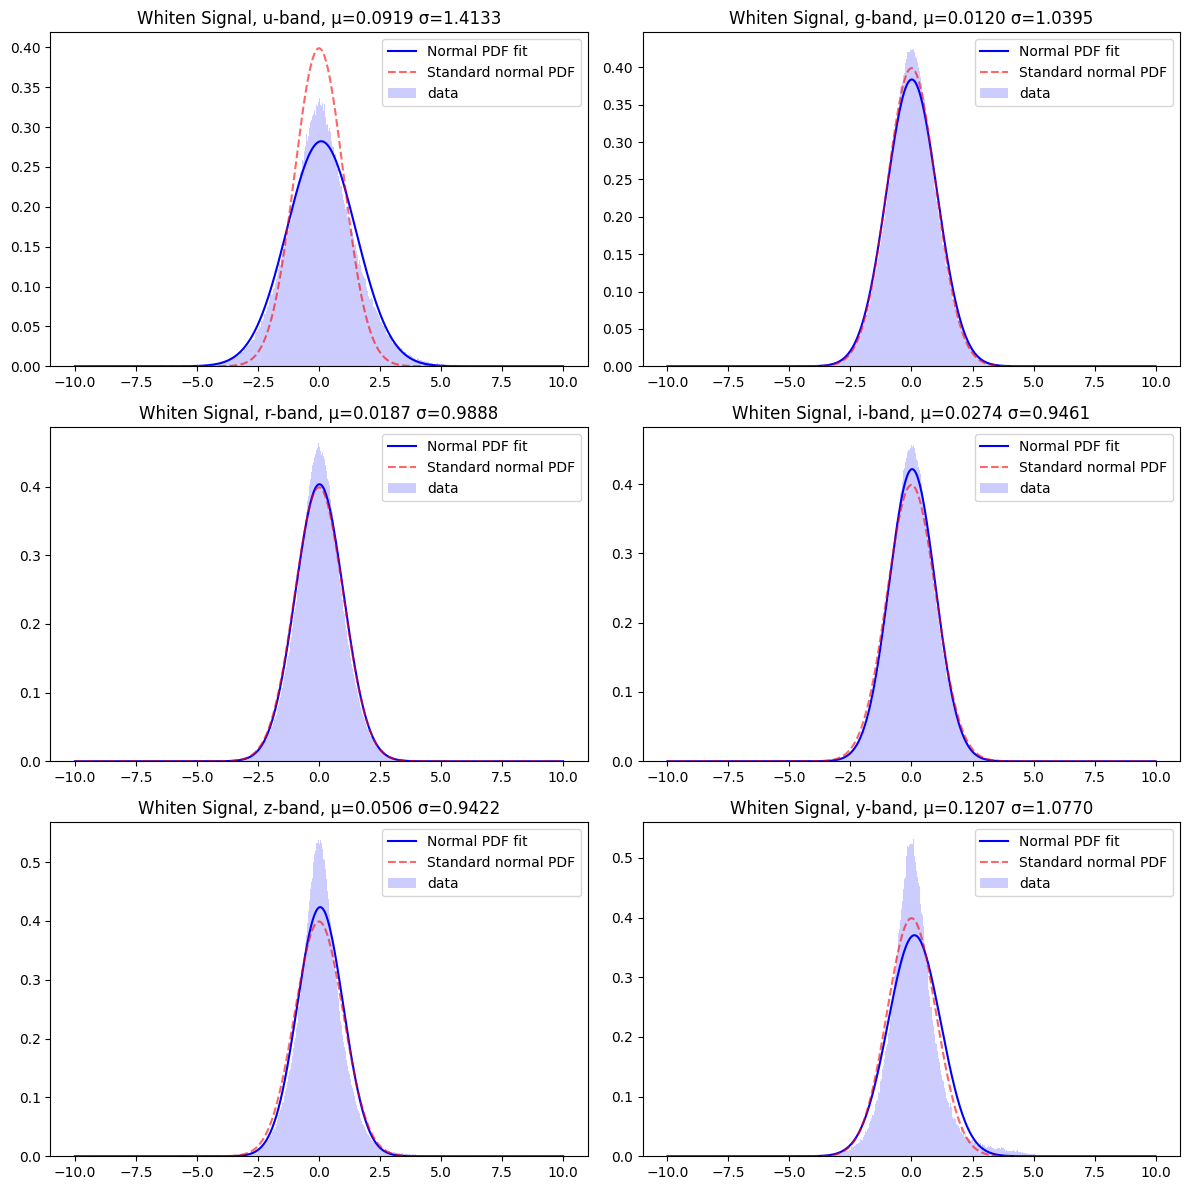

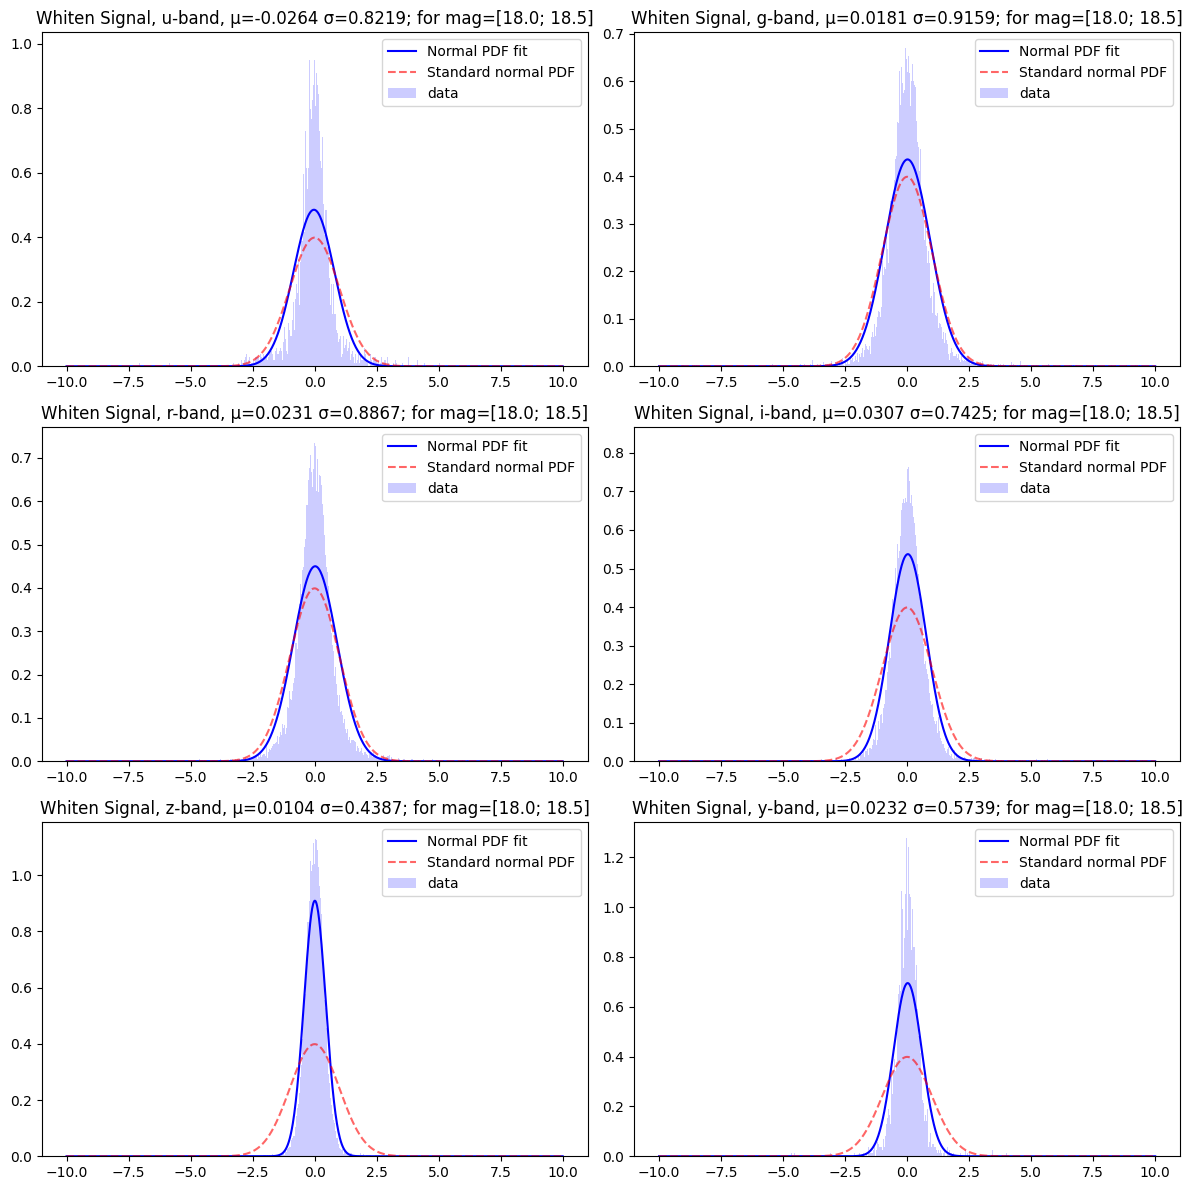

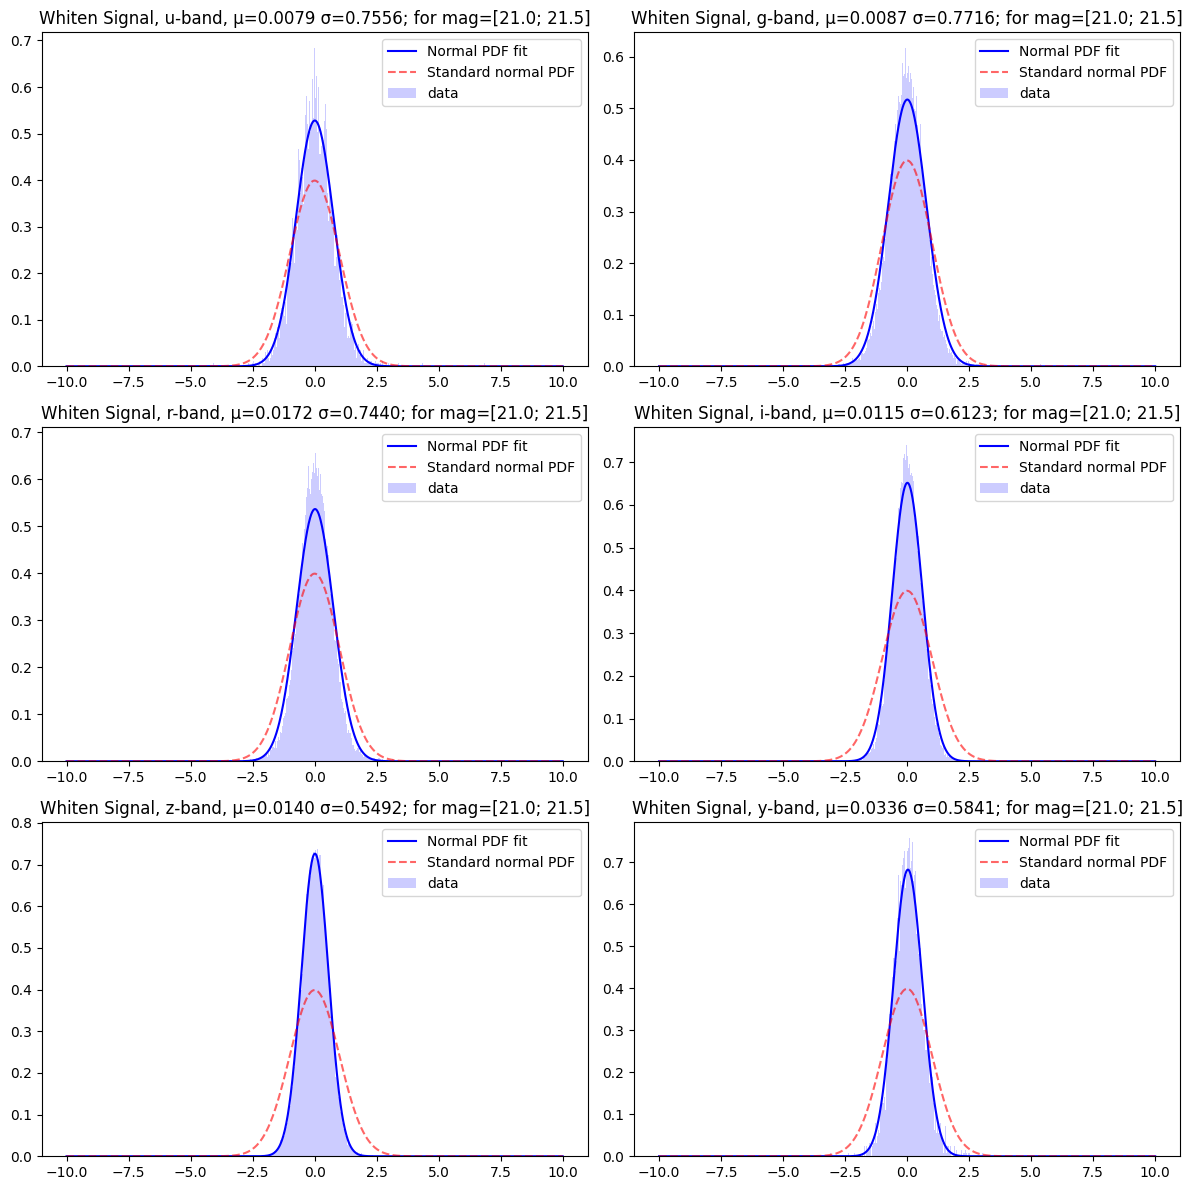

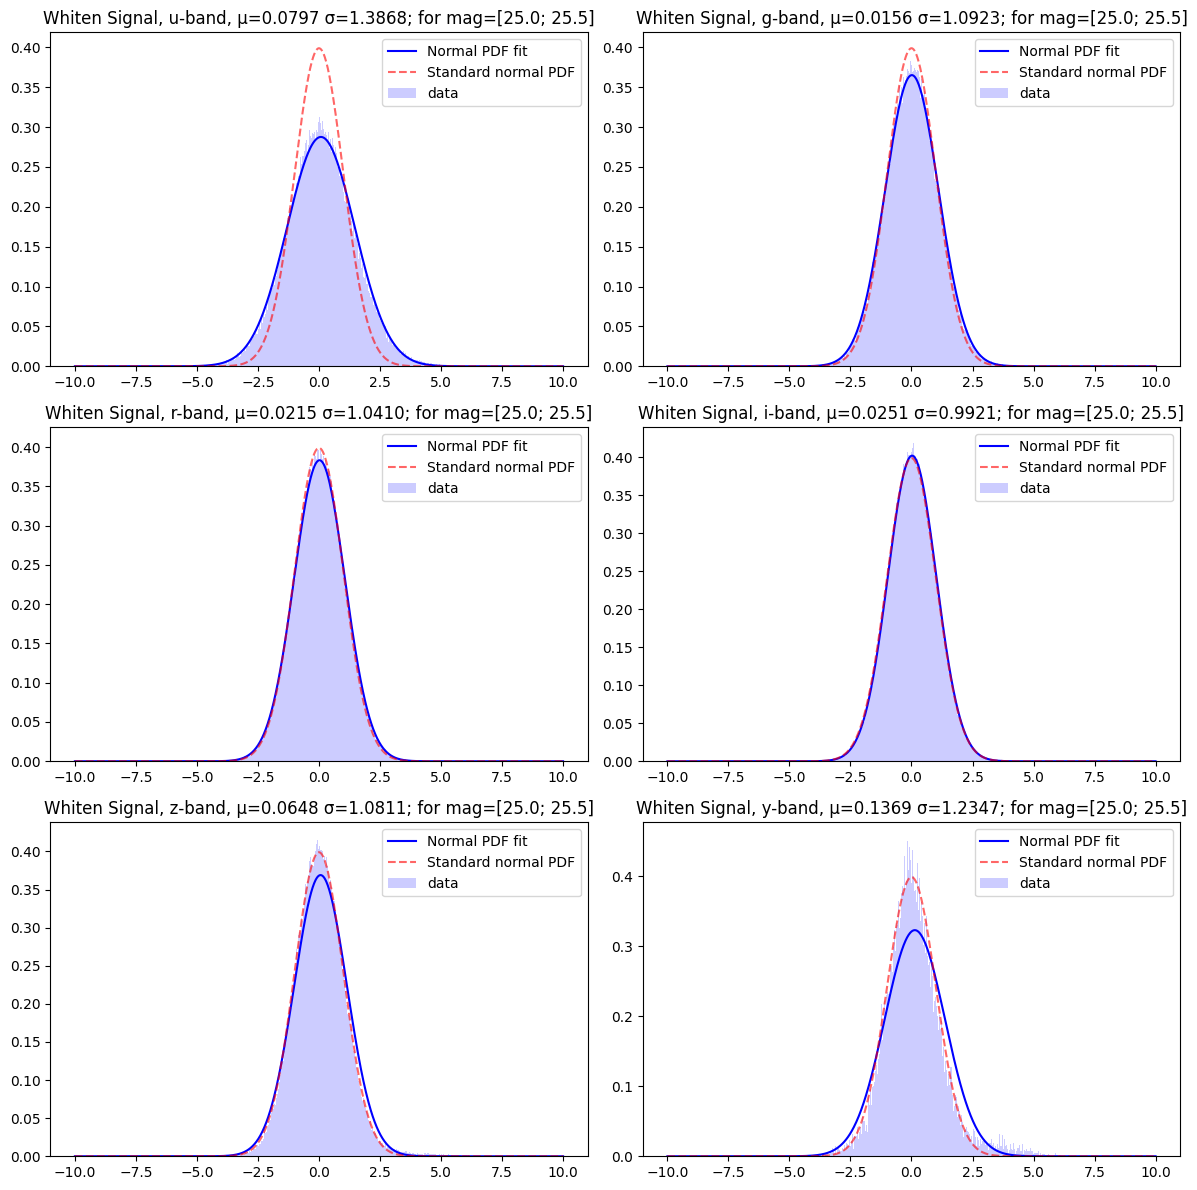

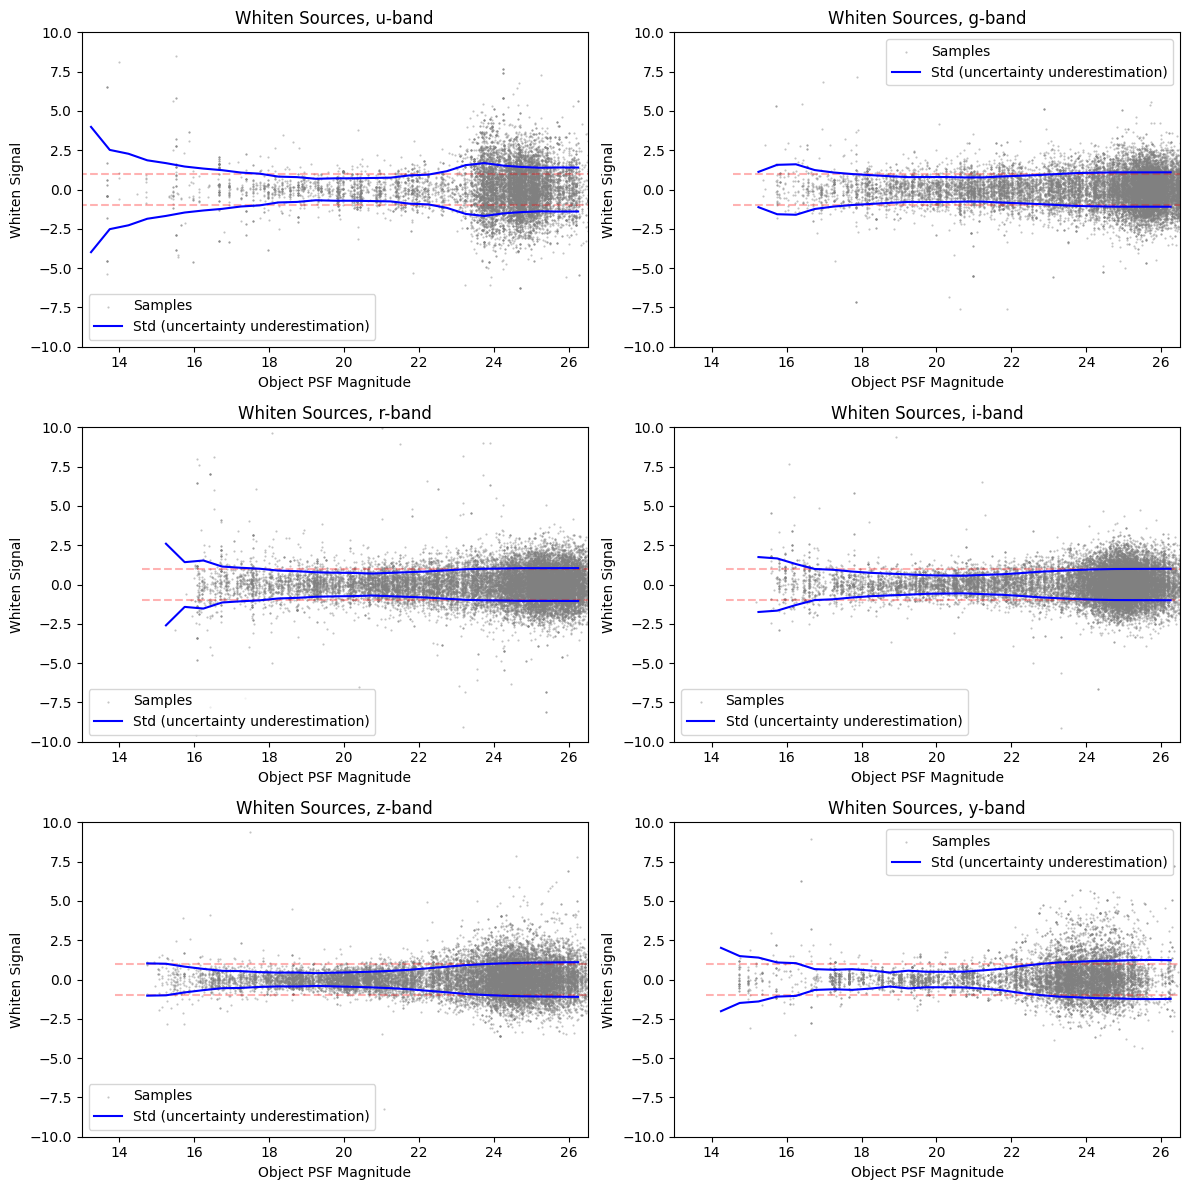

In [5]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    test_only=PLOT_ON_TEST_SET,
    min_n_src=N_SRC,
    non_extended_only=NON_EXTENDED_ONLY,
    n_workers=LSDB_WORKERS,
    model=model_path,
    n_samples=5,
    object_mags=[18, 21, 25],
)